## Assignment 2

In [7]:
import torch
torch.__version__

'0.4.0'

### Importing, normalizing and bootstrapping data

We are loading the data from `npz` numpy zip, splitting the training in train and validation sets and parsing those to tensor datasets for training pytorch models  

**TODO**: Bootstrap

In [450]:
import numpy as np
import torch.utils.data as data_utils
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

data_set = np.load('./prediction-challenge-01-data.npz')

X, y, test = data_set['data_x'], data_set['data_y'], data_set['test_x']

#### Let's try some bootstrapping

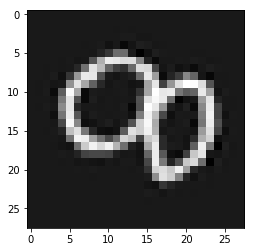

In [451]:
from scipy import ndimage
plt.imshow(ndimage.rotate(X[0][0], 65, reshape=False), cmap='gray')

In [452]:
mean_image = np.mean(X, axis=0)
X -= mean_image
test -= mean_image
train_x, validation_x, train_y, validation_y = train_test_split(X, y, test_size=.2)

print(X.shape)
print(y.shape)

(20000, 1, 28, 28)
(20000,)


### Rotate

Let's rotate the images a little bit in order to gain some more training data

In [453]:
new_x = train_x
new_y = train_y
for deg in range(15, 61, 15):
    new_data = []
    new_labels = y
    for i, x in enumerate(X):
        new_data.append([ndimage.rotate(x[0], 65, reshape=False)])
        
    new_x = np.vstack([new_x, new_data])
    new_y = np.append(new_y, new_labels)
train_x = new_x
train_y = new_y

In [454]:
train_dataset = data_utils.TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_dataset = data_utils.TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))

# to make sure everything is fine
print('Shape of training data: {}'.format(train_x.shape))
print('Labels\' shape: {}'.format(train_y.shape))

Shape of training data: (96000, 1, 28, 28)
Labels' shape: (96000,)


### Visualizing data

It's always good to know how our data looks like and what the corresponding labels are

6

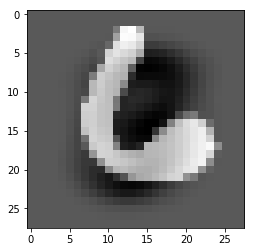

In [455]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_x[0][0], cmap='gray')
train_y[0]

8


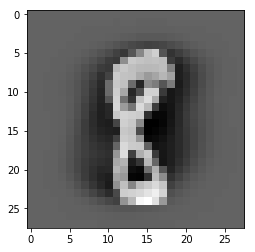

In [456]:
print(validation_y[0])
plt.imshow(validation_x[0][0], cmap='gray')

### Mean Image

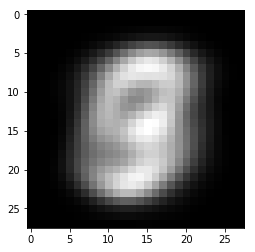

In [457]:
plt.imshow(mean_image[0], cmap='gray')

### Model

#### VGG

As done in "Mustererkennung" course in WS17, we used VGG, though not VGG11

We are using the VGG nets model. This is a pretty famous model and works great for recognizing images. Basic principle is to have some convolutional layers followed by pooling layers, the whole thing multiple times. Afterwards one usually has some number of fully connected layers, though this is originally not so in VGG. We decided to add the fully connected layers anyways, as we don't have the capcaity to run the original VGG model anyways.

Further info -> http://www.robots.ox.ac.uk/~vgg/research/very_deep/

#### Batchnorm, Dropout, Xavier

Bachnorm makes training a model quicker as it keeps mean and standart deviation consistant within the network (if the model decides it's helpful for it, how much batch normalisation is used is a learning parameter). Dropout makes sure the NN doesn't overfit, as it repeatedly temporarily disables some neurons so better generalisation is reached. Xavier is used for better weights initialisation.

#### First implementation

Score 99.2%; No FC layers, 0.005 learning rate

In [458]:
import torch.nn as nn
import torch.nn.functional as F

cfg = {
    'VGG': [4, 8, 'M', 16, 16, 'M', 32, 32, 'M', 32, 32, 'M', 'FC', 64, 128, 32]
}

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv_layers, self.fc_layers = self._make_layers(cfg['VGG'])
        self.classifier = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), x.size(1))
        x = self.fc_layers(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)
    
    def _make_layers(self, cfg):
        conv_layers = []
        fc_layers = []
        in_channels = 1
        build_fc = False
        
        for x in cfg:
            if build_fc:
                fc = nn.Linear(in_channels, x)
                fc_layers += [fc,
                           nn.BatchNorm1d(x),
                           nn.Dropout(p=0.05),
                           nn.ReLU(inplace=True)]
                nn.init.xavier_uniform_(fc.weight)
            elif x == 'M':
                conv_layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif x == 'FC':
                build_fc = True
            else:
                conv = nn.Conv2d(in_channels, x, kernel_size=3, padding=1)
                conv_layers += [conv,
                           nn.BatchNorm2d(x),
                           nn.Dropout(p=0.05),
                           nn.ReLU(inplace=True)]
                nn.init.xavier_uniform_(conv.weight)
                
            if isinstance(x, int):
                in_channels = x
        conv_layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
            
        return nn.Sequential(*conv_layers), nn.Sequential(*fc_layers)

In [459]:
model = VGG()
if torch.cuda.is_available():
    model.cuda()

In [465]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [466]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 1}
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=32, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=32,
                                          shuffle=False,
                                          **kwargs)

In [467]:
from torch.autograd import Variable

def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [468]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [469]:
%%time
for epoch in range(1, 5 + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/96000 (0%)]	Loss: 0.100748
Train Epoch: 1 [320/96000 (0%)]	Loss: 0.432821
Train Epoch: 1 [640/96000 (1%)]	Loss: 0.009601
Train Epoch: 1 [960/96000 (1%)]	Loss: 0.007317
Train Epoch: 1 [1280/96000 (1%)]	Loss: 0.199081
Train Epoch: 1 [1600/96000 (2%)]	Loss: 0.092225
Train Epoch: 1 [1920/96000 (2%)]	Loss: 0.013636
Train Epoch: 1 [2240/96000 (2%)]	Loss: 0.002149
Train Epoch: 1 [2560/96000 (3%)]	Loss: 0.066231
Train Epoch: 1 [2880/96000 (3%)]	Loss: 0.005993
Train Epoch: 1 [3200/96000 (3%)]	Loss: 0.012264
Train Epoch: 1 [3520/96000 (4%)]	Loss: 0.001725
Train Epoch: 1 [3840/96000 (4%)]	Loss: 0.085416
Train Epoch: 1 [4160/96000 (4%)]	Loss: 0.001109
Train Epoch: 1 [4480/96000 (5%)]	Loss: 0.006493
Train Epoch: 1 [4800/96000 (5%)]	Loss: 0.025273
Train Epoch: 1 [5120/96000 (5%)]	Loss: 0.002262
Train Epoch: 1 [5440/96000 (6%)]	Loss: 0.050968
Train Epoch: 1 [5760/96000 (6%)]	Loss: 0.072761
Train Epoch: 1 [6080/96000 (6%)]	Loss: 0.035332
Train Epoch: 1 [6400/96000 (7%)]	Loss: 0.00466

Train Epoch: 1 [53120/96000 (55%)]	Loss: 0.000512
Train Epoch: 1 [53440/96000 (56%)]	Loss: 0.123928
Train Epoch: 1 [53760/96000 (56%)]	Loss: 0.024254
Train Epoch: 1 [54080/96000 (56%)]	Loss: 0.009468
Train Epoch: 1 [54400/96000 (57%)]	Loss: 0.007951
Train Epoch: 1 [54720/96000 (57%)]	Loss: 0.000616
Train Epoch: 1 [55040/96000 (57%)]	Loss: 0.116020
Train Epoch: 1 [55360/96000 (58%)]	Loss: 0.000852
Train Epoch: 1 [55680/96000 (58%)]	Loss: 0.004461
Train Epoch: 1 [56000/96000 (58%)]	Loss: 0.025699
Train Epoch: 1 [56320/96000 (59%)]	Loss: 0.003339
Train Epoch: 1 [56640/96000 (59%)]	Loss: 0.034453
Train Epoch: 1 [56960/96000 (59%)]	Loss: 0.122226
Train Epoch: 1 [57280/96000 (60%)]	Loss: 0.012836
Train Epoch: 1 [57600/96000 (60%)]	Loss: 0.006663
Train Epoch: 1 [57920/96000 (60%)]	Loss: 0.003938
Train Epoch: 1 [58240/96000 (61%)]	Loss: 0.002040
Train Epoch: 1 [58560/96000 (61%)]	Loss: 0.002250
Train Epoch: 1 [58880/96000 (61%)]	Loss: 0.152589
Train Epoch: 1 [59200/96000 (62%)]	Loss: 0.004307


Train Epoch: 2 [9600/96000 (10%)]	Loss: 0.001511
Train Epoch: 2 [9920/96000 (10%)]	Loss: 0.001877
Train Epoch: 2 [10240/96000 (11%)]	Loss: 0.004117
Train Epoch: 2 [10560/96000 (11%)]	Loss: 0.026433
Train Epoch: 2 [10880/96000 (11%)]	Loss: 0.013807
Train Epoch: 2 [11200/96000 (12%)]	Loss: 0.013121
Train Epoch: 2 [11520/96000 (12%)]	Loss: 0.009292
Train Epoch: 2 [11840/96000 (12%)]	Loss: 0.017762
Train Epoch: 2 [12160/96000 (13%)]	Loss: 0.015861
Train Epoch: 2 [12480/96000 (13%)]	Loss: 0.001301
Train Epoch: 2 [12800/96000 (13%)]	Loss: 0.015147
Train Epoch: 2 [13120/96000 (14%)]	Loss: 0.002003
Train Epoch: 2 [13440/96000 (14%)]	Loss: 0.032141
Train Epoch: 2 [13760/96000 (14%)]	Loss: 0.053710
Train Epoch: 2 [14080/96000 (15%)]	Loss: 0.004993
Train Epoch: 2 [14400/96000 (15%)]	Loss: 0.023727
Train Epoch: 2 [14720/96000 (15%)]	Loss: 0.006545
Train Epoch: 2 [15040/96000 (16%)]	Loss: 0.000734
Train Epoch: 2 [15360/96000 (16%)]	Loss: 0.011745
Train Epoch: 2 [15680/96000 (16%)]	Loss: 0.000785
Tr

Train Epoch: 2 [62080/96000 (65%)]	Loss: 0.002579
Train Epoch: 2 [62400/96000 (65%)]	Loss: 0.002654
Train Epoch: 2 [62720/96000 (65%)]	Loss: 0.016055
Train Epoch: 2 [63040/96000 (66%)]	Loss: 0.002123
Train Epoch: 2 [63360/96000 (66%)]	Loss: 0.002469
Train Epoch: 2 [63680/96000 (66%)]	Loss: 0.007370
Train Epoch: 2 [64000/96000 (67%)]	Loss: 0.052708
Train Epoch: 2 [64320/96000 (67%)]	Loss: 0.025162
Train Epoch: 2 [64640/96000 (67%)]	Loss: 0.000632
Train Epoch: 2 [64960/96000 (68%)]	Loss: 0.023736
Train Epoch: 2 [65280/96000 (68%)]	Loss: 0.058434
Train Epoch: 2 [65600/96000 (68%)]	Loss: 0.147125
Train Epoch: 2 [65920/96000 (69%)]	Loss: 0.000861
Train Epoch: 2 [66240/96000 (69%)]	Loss: 0.023896
Train Epoch: 2 [66560/96000 (69%)]	Loss: 0.039122
Train Epoch: 2 [66880/96000 (70%)]	Loss: 0.000302
Train Epoch: 2 [67200/96000 (70%)]	Loss: 0.097103
Train Epoch: 2 [67520/96000 (70%)]	Loss: 0.004629
Train Epoch: 2 [67840/96000 (71%)]	Loss: 0.051326
Train Epoch: 2 [68160/96000 (71%)]	Loss: 0.000769


Train Epoch: 3 [18560/96000 (19%)]	Loss: 0.001990
Train Epoch: 3 [18880/96000 (20%)]	Loss: 0.012256
Train Epoch: 3 [19200/96000 (20%)]	Loss: 0.045095
Train Epoch: 3 [19520/96000 (20%)]	Loss: 0.000653
Train Epoch: 3 [19840/96000 (21%)]	Loss: 0.223765
Train Epoch: 3 [20160/96000 (21%)]	Loss: 0.067364
Train Epoch: 3 [20480/96000 (21%)]	Loss: 0.027199
Train Epoch: 3 [20800/96000 (22%)]	Loss: 0.000265
Train Epoch: 3 [21120/96000 (22%)]	Loss: 0.005569
Train Epoch: 3 [21440/96000 (22%)]	Loss: 0.001512
Train Epoch: 3 [21760/96000 (23%)]	Loss: 0.000372
Train Epoch: 3 [22080/96000 (23%)]	Loss: 0.002037
Train Epoch: 3 [22400/96000 (23%)]	Loss: 0.088216
Train Epoch: 3 [22720/96000 (24%)]	Loss: 0.005728
Train Epoch: 3 [23040/96000 (24%)]	Loss: 0.010538
Train Epoch: 3 [23360/96000 (24%)]	Loss: 0.005958
Train Epoch: 3 [23680/96000 (25%)]	Loss: 0.000788
Train Epoch: 3 [24000/96000 (25%)]	Loss: 0.074605
Train Epoch: 3 [24320/96000 (25%)]	Loss: 0.065294
Train Epoch: 3 [24640/96000 (26%)]	Loss: 0.001283


Train Epoch: 3 [71040/96000 (74%)]	Loss: 0.005309
Train Epoch: 3 [71360/96000 (74%)]	Loss: 0.000635
Train Epoch: 3 [71680/96000 (75%)]	Loss: 0.000689
Train Epoch: 3 [72000/96000 (75%)]	Loss: 0.000471
Train Epoch: 3 [72320/96000 (75%)]	Loss: 0.001151
Train Epoch: 3 [72640/96000 (76%)]	Loss: 0.001693
Train Epoch: 3 [72960/96000 (76%)]	Loss: 0.000434
Train Epoch: 3 [73280/96000 (76%)]	Loss: 0.003231
Train Epoch: 3 [73600/96000 (77%)]	Loss: 0.067594
Train Epoch: 3 [73920/96000 (77%)]	Loss: 0.117314
Train Epoch: 3 [74240/96000 (77%)]	Loss: 0.008854
Train Epoch: 3 [74560/96000 (78%)]	Loss: 0.000852
Train Epoch: 3 [74880/96000 (78%)]	Loss: 0.003798
Train Epoch: 3 [75200/96000 (78%)]	Loss: 0.030412
Train Epoch: 3 [75520/96000 (79%)]	Loss: 0.000848
Train Epoch: 3 [75840/96000 (79%)]	Loss: 0.052086
Train Epoch: 3 [76160/96000 (79%)]	Loss: 0.049043
Train Epoch: 3 [76480/96000 (80%)]	Loss: 0.038297
Train Epoch: 3 [76800/96000 (80%)]	Loss: 0.001103
Train Epoch: 3 [77120/96000 (80%)]	Loss: 0.000341


Train Epoch: 4 [27520/96000 (29%)]	Loss: 0.002570
Train Epoch: 4 [27840/96000 (29%)]	Loss: 0.013143
Train Epoch: 4 [28160/96000 (29%)]	Loss: 0.001115
Train Epoch: 4 [28480/96000 (30%)]	Loss: 0.016233
Train Epoch: 4 [28800/96000 (30%)]	Loss: 0.001755
Train Epoch: 4 [29120/96000 (30%)]	Loss: 0.006474
Train Epoch: 4 [29440/96000 (31%)]	Loss: 0.000923
Train Epoch: 4 [29760/96000 (31%)]	Loss: 0.000626
Train Epoch: 4 [30080/96000 (31%)]	Loss: 0.027072
Train Epoch: 4 [30400/96000 (32%)]	Loss: 0.002183
Train Epoch: 4 [30720/96000 (32%)]	Loss: 0.096204
Train Epoch: 4 [31040/96000 (32%)]	Loss: 0.002551
Train Epoch: 4 [31360/96000 (33%)]	Loss: 0.006418
Train Epoch: 4 [31680/96000 (33%)]	Loss: 0.002571
Train Epoch: 4 [32000/96000 (33%)]	Loss: 0.002297
Train Epoch: 4 [32320/96000 (34%)]	Loss: 0.027003
Train Epoch: 4 [32640/96000 (34%)]	Loss: 0.003520
Train Epoch: 4 [32960/96000 (34%)]	Loss: 0.040245
Train Epoch: 4 [33280/96000 (35%)]	Loss: 0.006282
Train Epoch: 4 [33600/96000 (35%)]	Loss: 0.003127


Train Epoch: 4 [80000/96000 (83%)]	Loss: 0.028478
Train Epoch: 4 [80320/96000 (84%)]	Loss: 0.030007
Train Epoch: 4 [80640/96000 (84%)]	Loss: 0.002144
Train Epoch: 4 [80960/96000 (84%)]	Loss: 0.003994
Train Epoch: 4 [81280/96000 (85%)]	Loss: 0.000253
Train Epoch: 4 [81600/96000 (85%)]	Loss: 0.000648
Train Epoch: 4 [81920/96000 (85%)]	Loss: 0.001753
Train Epoch: 4 [82240/96000 (86%)]	Loss: 0.000315
Train Epoch: 4 [82560/96000 (86%)]	Loss: 0.000514
Train Epoch: 4 [82880/96000 (86%)]	Loss: 0.028255
Train Epoch: 4 [83200/96000 (87%)]	Loss: 0.000859
Train Epoch: 4 [83520/96000 (87%)]	Loss: 0.000710
Train Epoch: 4 [83840/96000 (87%)]	Loss: 0.001220
Train Epoch: 4 [84160/96000 (88%)]	Loss: 0.000470
Train Epoch: 4 [84480/96000 (88%)]	Loss: 0.032698
Train Epoch: 4 [84800/96000 (88%)]	Loss: 0.001749
Train Epoch: 4 [85120/96000 (89%)]	Loss: 0.002832
Train Epoch: 4 [85440/96000 (89%)]	Loss: 0.007419
Train Epoch: 4 [85760/96000 (89%)]	Loss: 0.001654
Train Epoch: 4 [86080/96000 (90%)]	Loss: 0.002906


Train Epoch: 5 [36480/96000 (38%)]	Loss: 0.054313
Train Epoch: 5 [36800/96000 (38%)]	Loss: 0.002443
Train Epoch: 5 [37120/96000 (39%)]	Loss: 0.001873
Train Epoch: 5 [37440/96000 (39%)]	Loss: 0.000382
Train Epoch: 5 [37760/96000 (39%)]	Loss: 0.003804
Train Epoch: 5 [38080/96000 (40%)]	Loss: 0.000994
Train Epoch: 5 [38400/96000 (40%)]	Loss: 0.004276
Train Epoch: 5 [38720/96000 (40%)]	Loss: 0.000875
Train Epoch: 5 [39040/96000 (41%)]	Loss: 0.043564
Train Epoch: 5 [39360/96000 (41%)]	Loss: 0.004292
Train Epoch: 5 [39680/96000 (41%)]	Loss: 0.013403
Train Epoch: 5 [40000/96000 (42%)]	Loss: 0.001047
Train Epoch: 5 [40320/96000 (42%)]	Loss: 0.009252
Train Epoch: 5 [40640/96000 (42%)]	Loss: 0.208627
Train Epoch: 5 [40960/96000 (43%)]	Loss: 0.139538
Train Epoch: 5 [41280/96000 (43%)]	Loss: 0.000393
Train Epoch: 5 [41600/96000 (43%)]	Loss: 0.000500
Train Epoch: 5 [41920/96000 (44%)]	Loss: 0.000346
Train Epoch: 5 [42240/96000 (44%)]	Loss: 0.004735
Train Epoch: 5 [42560/96000 (44%)]	Loss: 0.131079


Train Epoch: 5 [88960/96000 (93%)]	Loss: 0.008368
Train Epoch: 5 [89280/96000 (93%)]	Loss: 0.005040
Train Epoch: 5 [89600/96000 (93%)]	Loss: 0.000952
Train Epoch: 5 [89920/96000 (94%)]	Loss: 0.000625
Train Epoch: 5 [90240/96000 (94%)]	Loss: 0.082785
Train Epoch: 5 [90560/96000 (94%)]	Loss: 0.006766
Train Epoch: 5 [90880/96000 (95%)]	Loss: 0.001608
Train Epoch: 5 [91200/96000 (95%)]	Loss: 0.000265
Train Epoch: 5 [91520/96000 (95%)]	Loss: 0.010226
Train Epoch: 5 [91840/96000 (96%)]	Loss: 0.002886
Train Epoch: 5 [92160/96000 (96%)]	Loss: 0.026167
Train Epoch: 5 [92480/96000 (96%)]	Loss: 0.000995
Train Epoch: 5 [92800/96000 (97%)]	Loss: 0.002390
Train Epoch: 5 [93120/96000 (97%)]	Loss: 0.000897
Train Epoch: 5 [93440/96000 (97%)]	Loss: 0.000288
Train Epoch: 5 [93760/96000 (98%)]	Loss: 0.000353
Train Epoch: 5 [94080/96000 (98%)]	Loss: 0.023201
Train Epoch: 5 [94400/96000 (98%)]	Loss: 0.010870
Train Epoch: 5 [94720/96000 (99%)]	Loss: 0.007315
Train Epoch: 5 [95040/96000 (99%)]	Loss: 0.043622
